<a href="https://colab.research.google.com/github/revak18/nicotine_use_mathmodel/blob/main/NicotineUse_SIR_DDE_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install ddeint

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from ddeint import ddeint

# Constants
B = 0.00103  # Birth rate per month
mu = 0.0006254  # Death rate per month
aging_rate_y_to_ya = 1 / (7 * 12) # 7 years to transition from 'youth' (11yrs) to 'young adult' (18yrs)
aging_rate_ya_to_a = 1 / (5 * 12)  # 5 years to transition from 'young adult' (18yrs)  to 'adult' (23yrs)
tau_1, tau_2, tau_3 = 12, 6, 18  # Delays for infection, recovery, and relapse

# Time-varying rate functions
# beta: Rate of infection
def beta(t):
    #return 0.002 + 0.001 * np.cos(t / 12 * np.pi)  # Seasonal variation in initiation
    return 0.18

#gamma: Rate of recovery
def gamma(t):
    #return 0.05 - 0.01 * np.cos(t / 12 * np.pi)  # Variation due to health campaign effectiveness
    return 0.05641

#rho: Rate of relapse
def rho(t):
    #return 0.03 + 0.01 * np.sin(t / 12 * np.pi)  # Variation due to economic and social stress
    return 0.076

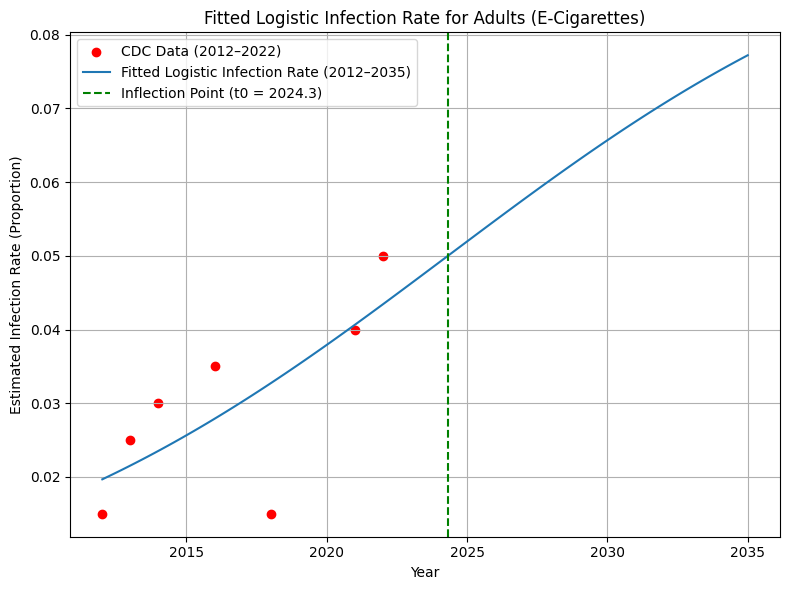

Fitted Parameters:
Growth Rate (r): 0.11420666423423377
Carrying Capacity (K): 0.09999999999743708
Inflection Year (t0): 2024.3164005538556


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Define the logistic function
def logistic_function(t, r, K, t0):
    """
    Logistic function for infection rate.
    Args:
        t: Time in years.
        r: Growth rate of infection.
        K: Carrying capacity (maximum infection rate).
        t0: Inflection year (stabilization starts).
    Returns:
        Infection rate at time t.
    """
    return K / (1 + np.exp(-r * (t - t0)))

# Use the historical CDC data
years = np.array([2012, 2013, 2014, 2016, 2018, 2021, 2022])  # Time in years
infection_rates = np.array([0.015, 0.025, 0.03, 0.035, 0.015, 0.04, 0.05])  # Proportions

# Fit the logistic model to the historical data
params, _ = curve_fit(
    logistic_function,
    years,
    infection_rates,
    p0=[0.1, 0.05, 2022],  # Initial guesses for r, K, t0
    bounds=([0, 0.01, 2010], [1, 0.1, 2030])  # Bounds for the parameters
)

# Extract fitted parameters
r_fitted, K_fitted, t0_fitted = params

# Define the logistic infection rate function using the fitted parameters
def beta_realistic(t):
    """
    Logistic infection rate function for use in DDE-SIR.
    Args:
        t: Time in months (e.g., t=0 corresponds to 2012).
    Returns:
        Infection rate at time t.
    """
    year = 2012 + t / 12  # Convert time in months to years
    return K_fitted / (1 + np.exp(-r_fitted * (year - t0_fitted)))

# Test the fitted logistic function
future_years = np.linspace(2012, 2035, 100)  # Time from 2012 to 2035
fitted_infection_rates = logistic_function(future_years, r_fitted, K_fitted, t0_fitted)

# Plot the fitted model and historical data
plt.figure(figsize=(8, 6))
plt.scatter(years, infection_rates, color='red', label="CDC Data (2012–2022)")
plt.plot(future_years, fitted_infection_rates, label="Fitted Logistic Infection Rate (2012–2035)")
plt.axvline(x=t0_fitted, color='green', linestyle='--', label=f"Inflection Point (t0 = {t0_fitted:.1f})")
plt.xlabel("Year")
plt.ylabel("Estimated Infection Rate (Proportion)")
plt.title("Fitted Logistic Infection Rate for Adults (E-Cigarettes)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Display the fitted parameters
print(f"Fitted Parameters:")
print(f"Growth Rate (r): {r_fitted}")
print(f"Carrying Capacity (K): {K_fitted}")
print(f"Inflection Year (t0): {t0_fitted}")


In [ ]:
Year   Month   Beta (Infection Rate)
2023   0       0.028722
2024   0       0.032568
2025   0       0.035803
2026   0       0.038647
2027   0       0.041064
2028   0       0.043123
2029   0       0.044890
2030   0       0.046425
2031   0       0.047780
2032   0       0.048999
2033   0       0.050110


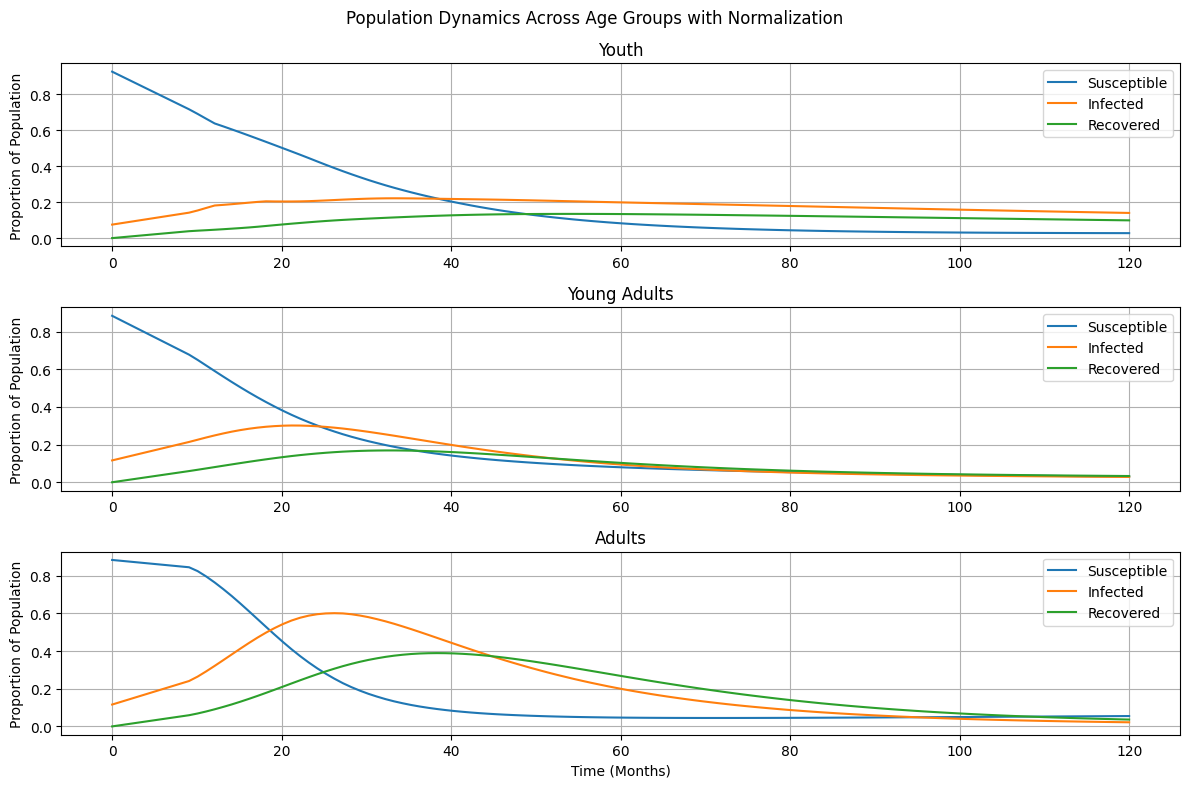

In [8]:
#S_y, I_y, R_y: Proportion of susceptible, infected, and recovered individuals in the Youth age group.
#S_ya, I_ya, R_ya: Proportion of susceptible, infected, and recovered individuals in the Young Adult age group.
#S_a, I_a, R_a: Proportion of susceptible, infected, and recovered individuals in the Adult age group.
#τ₁ (tau_1), τ₂ (tau_2), and τ₃ (tau_3): Delays associated with initiation, cessation, and relapse processes.
#These delays reflect the time lag between exposure to nicotine use and the onset of regular use,
# the time required for successful cessation, and the time it takes for a former user to relapse.

# Model definition
def model(Y, t):
    S_y, I_y, R_y, S_ya, I_ya, R_ya, S_a, I_a, R_a = Y(t)

    # Accessing delayed values using indexing
    if t >= tau_1:
        S_y_delay = Y(t - tau_1)[0]
        I_y_delay = Y(t - tau_1)[1]
        R_y_delay = Y(t - tau_1)[2]
    else:
        S_y_delay, I_y_delay, R_y_delay = S_y, I_y, R_y

    if t >= tau_2:
        I_y_delay2 = Y(t - tau_2)[1]
    else:
        I_y_delay2 = I_y

    if t >= tau_3:
        R_y_delay3 = Y(t - tau_3)[2]
    else:
        R_y_delay3 = R_y

    # Population dynamics
    dS_y_dt = B - beta(t) * S_y * I_y_delay - mu * S_y - aging_rate_y_to_ya * S_y
    dI_y_dt = beta(t) * S_y * I_y_delay - (mu + gamma(t)) * I_y_delay2 + rho(t) * R_y_delay3 - aging_rate_y_to_ya * I_y
    dR_y_dt = gamma(t) * I_y_delay2 - (mu + rho(t)) * R_y - aging_rate_y_to_ya * R_y

    dS_ya_dt = S_y * aging_rate_y_to_ya - beta(t) * S_ya * I_ya - mu * S_ya - aging_rate_ya_to_a * S_ya
    dI_ya_dt = I_y * aging_rate_y_to_ya + beta(t) * S_ya * I_ya - (mu + gamma(t)) * I_ya - aging_rate_ya_to_a * I_ya
    dR_ya_dt = R_y * aging_rate_y_to_ya + gamma(t) * I_ya - (mu + rho(t)) * R_ya - aging_rate_ya_to_a * R_ya

    dS_a_dt = S_ya * aging_rate_ya_to_a - beta(t) * S_a * I_a - mu * S_a
    dI_a_dt = I_ya * aging_rate_ya_to_a + beta(t) * S_a * I_a - (mu + gamma(t)) * I_a
    dR_a_dt = R_ya * aging_rate_ya_to_a + gamma(t) * I_a - (mu + rho(t)) * R_a

    return [dS_y_dt, dI_y_dt, dR_y_dt, dS_ya_dt, dI_ya_dt, dR_ya_dt, dS_a_dt, dI_a_dt, dR_a_dt]

# Initial conditions and history function
# Ref: https://www.cdc.gov/tobacco/media/pdfs/2024/09/cdc-osh-ncis-data-report-508.pdf
# Percent of adults age 18 and older who currently smoke: For this model *** "Adults" and "Yound Adults" ***
# E-cigarettes: 6.0% --> Infected, I0 = 0.0600 , Susceptible, S0 = 1 - I0 = 1 - 0.0600 = 0.9400, Recovered, R0 = 0.0  Initially, no individuals have quit nicotine use.
# cigarettes: 11.6%  --> Infected, I0 = 0.1160 , Susceptible, S0 = 1 - I0 = 1 - 0.1160 = 0.8840, Recovered, R0 = 0.0  Initially, no individuals have quit nicotine use.

# Ref: https://www.cdc.gov/nchs/fastats/smoking.htm
# Percent of adolescents who currently smoke: For this model "Youth"
# E-cigarettes: 24.7% --> Infected, I0 = 0.2470 , Susceptible, S0 = 1 - I0 = 1 - 0.2470 = 0.7530, Recovered, R0 = 0.0  Initially, no individuals have quit nicotine use.
# cigarettes: 7.5%    --> Infected, I0 = 0.0750 , Susceptible, S0 = 1 - I0 = 1 - 0.0750 = 0.9250, Recovered, R0 = 0.0  Initially, no individuals have quit nicotine use.

#E-cigarettes "Adults" and "Yound Adults" : S0, I0, R0 = 0.9400, 0.0600, 0.0000
#E-cigarettes "Youth"                     : S0, I0, R0 = 0.7530, 0.2470, 0.0000
#cigarettes "Adults" and "Yound Adults"   : S0, I0, R0 = 0.8840, 0.1160, 0.0000
#cigarettes "Youth"                       : S0, I0, R0 = 0.9250, 0.0750, 0.0000

def history(t):
    #return [0.7530, 0.2470, 0.0000, 0.9400, 0.0600, 0.0000, 0.9400, 0.0600, 0.0000]  # Initial values for E-cigarettes all states of Youth, Young Adults and Adults
    return [0.9250, 0.0750, 0.0000, 0.8840, 0.1160, 0.0000, 0.8840, 0.1160, 0.0000]  # Initial values for Cigarettes all states of Youth, Young Adults and Adults

# Time vector
t = np.linspace(0, 120, 120)  # Simulate for 10 years

# Solve DDE
sol = ddeint(model, history, t)

# Normalize the solution (after solving DDE)
#total_pop = sol.sum(axis=1)  # Sum across all population groups
#sol = sol / total_pop[:, np.newaxis]  # Normalize each group by total population

# Plotting results
plt.figure(figsize=(12, 8))
# Subplot for Youth
plt.subplot(3, 1, 1)
plt.plot(t, sol[:, 0], label='Susceptible')
plt.plot(t, sol[:, 1], label='Infected')
plt.plot(t, sol[:, 2], label='Recovered')
plt.title('Youth')
plt.ylabel('Proportion of Population')
plt.legend()
plt.grid(True)

# Subplot for Young Adults
plt.subplot(3, 1, 2)
plt.plot(t, sol[:, 3], label='Susceptible')
plt.plot(t, sol[:, 4], label='Infected')
plt.plot(t, sol[:, 5], label='Recovered')
plt.title('Young Adults')
plt.ylabel('Proportion of Population')
plt.legend()
plt.grid(True)

# Subplot for Adults
plt.subplot(3, 1, 3)
plt.plot(t, sol[:, 6], label='Susceptible')
plt.plot(t, sol[:, 7], label='Infected')
plt.plot(t, sol[:, 8], label='Recovered')
plt.title('Adults')
plt.xlabel('Time (Months)')
plt.ylabel('Proportion of Population')
plt.legend()
plt.grid(True)

plt.suptitle('Population Dynamics Across Age Groups with Normalization')
plt.tight_layout()
plt.show()